# Our mode: the dilated convolution neural network

## Imports

In [10]:
import glob
import numpy as np
import matplotlib.pyplot as plt
#import the Sequential model class. 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input

#Core layers 
from tensorflow.keras.layers import Dense, Activation, Flatten

#Convolution layers 
from tensorflow.keras.layers import Conv1D

# from tensorflow.keras.layers import Concatenate, concatenate

#Pooling layers 
# from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, AveragePooling1D, AveragePooling2D 

#Recurrent layers 
# from tensorflow.keras.layers import Recurrent, SimpleRNN, GRU, LSTM

#Embedding layers 
# from tensorflow.keras.layers import Embedding

#Merge layers 
# from tensorflow.keras.layers import Add, Multiply, Average, Maximum, Concatenate, Dot

#Normalization layers 
from tensorflow.keras.layers import BatchNormalization 

# from tensorflow.keras.models import load_model

from scipy.stats import spearmanr, pearsonr

## Global Variables

In [11]:
# data processing
num_bp_in_peak = 3000
num_bp_padding = 5000
down_sample = 1.0
margin = num_bp_in_peak/2 + num_bp_padding
dir_name = '/data/smooth_muscle_cells'
fasta_file = '/data/GRCh38.p3.genome.fa'
bigwig_file = '/data/TQ326-pooled_ATAC_USPD16083803_HHHJMBBXX_L4_1.merged.nodup.no_chrM_MT.tn5.fc.signal.bigwig'
peak_file = '/data/rep1-pr1_vs_rep1-pr2.overlap.bfilt.narrowPeak.gz'
test = 0.1
validation = 0.1
min_prominence = 0.7

# model
normalization = True
max_peak_val = 5
num_filters = 32
kernel_size = 24
pooling_size = 4
dilation_rate = 2
dropout_rate = 0.3
final_peak_size = 2764

# data
num_validation_examples = 11988
num_test_examples = 10288
num_training_examples = 105642 - num_validation_examples - num_test_examples
total = 105642

# training
num_training_examples_in_batch = 10000

## Model

In [12]:
# new model
from tensorflow.python.keras import backend

def get_model():
#     initial_convolution = Conv1D(num_filters, kernel_size, input_shape=(13000, 4))
#     second_convolution = Conv1D(num_filters, kernel_size)
#     first_dilation_1 = Conv1D(int(num_filters/2), int(kernel_size/2), dilation_rate=5)
#     first_dilation_2 = Conv1D(int(num_filters/2), int(kernel_size/2), dilation_rate=5)
#     second_dilation_1 = Conv1D(int(num_filters/4), int(kernel_size/4), dilation_rate=25)
#     second_dilation_2 = Conv1D(int(num_filters/4), int(kernel_size/4), dilation_rate=25)
#     third_dilation_1 = Conv1D(int(num_filters/8), int(kernel_size/4), dilation_rate=125)
#     third_dilation_2 = Conv1D(int(num_filters/8), int(kernel_size/4), dilation_rate=125)
#     fourth_dilation_1 = Conv1D(int(num_filters/16), int(kernel_size/4), dilation_rate=256)
#     fourth_dilation_2 = Conv1D(int(num_filters/16), int(kernel_size/4), dilation_rate=256)
#     fifth_dilation_1 = Conv1D(int(num_filters/32), int(kernel_size/4), dilation_rate=625)
#     fifth_dilation_2 = Conv1D(int(num_filters/32), int(kernel_size/4), dilation_rate=625)

    initial_convolution = Conv1D(num_filters, kernel_size, input_shape=(13000, 4))
    second_convolution = Conv1D(num_filters, kernel_size)
    first_dilation_1 = Conv1D(int(num_filters/2), int(kernel_size/6), dilation_rate=5)
    first_dilation_2 = Conv1D(int(num_filters/2), int(kernel_size/6), dilation_rate=5)
    second_dilation_1 = Conv1D(int(num_filters/4), int(kernel_size/6), dilation_rate=25)
    second_dilation_2 = Conv1D(int(num_filters/4), int(kernel_size/6), dilation_rate=25)
    add_dilation_1 = Conv1D(int(num_filters/4), int(kernel_size/6), dilation_rate=75)
    add_dilation_2 = Conv1D(int(num_filters/4), int(kernel_size/6), dilation_rate=75)
    third_dilation_1 = Conv1D(int(num_filters/8), int(kernel_size/4), dilation_rate=125)
    third_dilation_2 = Conv1D(int(num_filters/8), int(kernel_size/4), dilation_rate=125)
    ann_dilation_1 = Conv1D(int(num_filters/16), int(kernel_size/4), dilation_rate=200)
    ann_dilation_2 = Conv1D(int(num_filters/16), int(kernel_size/4), dilation_rate=200)
    fourth_dilation_1 = Conv1D(int(num_filters/16), int(kernel_size/4), dilation_rate=256)
    fourth_dilation_2 = Conv1D(int(num_filters/16), int(kernel_size/4), dilation_rate=256)
    fifth_dilation_1 = Conv1D(int(num_filters/32), int(kernel_size/4), dilation_rate=375)
    fifth_dilation_2 = Conv1D(int(num_filters/32), int(kernel_size/4), dilation_rate=375)

    input_seq = Input(shape=(13000, 4))

    initial_conv = initial_convolution(input_seq)
    initial_conv = BatchNormalization()(initial_conv)
    initial_conv = Activation('relu')(initial_conv)

    second_conv = second_convolution(initial_conv)
    second_conv = BatchNormalization()(second_conv)
    second_conv = Activation('relu')(second_conv)

    with backend.get_graph().as_default():
        first_dilation_1.build(second_conv.shape) 
    first_dilation = first_dilation_1(second_conv)
    first_dilation = BatchNormalization()(first_dilation)
    first_dilation = Activation('relu')(first_dilation)
    print(first_dilation.shape)

    with backend.get_graph().as_default():
        first_dilation_2.build(first_dilation.shape) 
    first_dilation = first_dilation_2(first_dilation)
    first_dilation = BatchNormalization()(first_dilation)
    first_dilation = Activation('relu')(first_dilation)
    print(first_dilation.shape)

    with backend.get_graph().as_default():
        second_dilation_1.build(first_dilation.shape) 
    second_dilation = second_dilation_1(first_dilation)
    second_dilation = BatchNormalization()(second_dilation)
    second_dilation = Activation('relu')(second_dilation)
    print(second_dilation.shape)

    with backend.get_graph().as_default():
        second_dilation_2.build(second_dilation.shape) 
    second_dilation = second_dilation_2(second_dilation)
    second_dilation = BatchNormalization()(second_dilation)
    second_dilation = Activation('relu')(second_dilation)

    print(second_dilation.shape)
    
    with backend.get_graph().as_default():
        add_dilation_1.build(second_dilation.shape) 
    add_dilation = add_dilation_1(second_dilation)
    add_dilation = BatchNormalization()(add_dilation)
    add_dilation = Activation('relu')(add_dilation)
    print(add_dilation.shape)

    with backend.get_graph().as_default():
        add_dilation_2.build(add_dilation.shape) 
    add_dilation = add_dilation_2(add_dilation)
    add_dilation = BatchNormalization()(add_dilation)
    add_dilation = Activation('relu')(add_dilation)

    print(add_dilation.shape)

    with backend.get_graph().as_default():
        third_dilation_1.build(add_dilation.shape) 
    third_dilation = third_dilation_1(add_dilation)
    third_dilation = BatchNormalization()(third_dilation)
    third_dilation = Activation('relu')(third_dilation)
    print(third_dilation.shape)

    with backend.get_graph().as_default():
         third_dilation_2.build(third_dilation.shape) 
    third_dilation =  third_dilation_2(third_dilation)
    third_dilation = BatchNormalization()(third_dilation)
    third_dilation = Activation('relu')(third_dilation)

    print(third_dilation.shape)
    
    with backend.get_graph().as_default():
        ann_dilation_1.build(third_dilation.shape) 
    ann_dilation = ann_dilation_1(third_dilation)
    ann_dilation = BatchNormalization()(ann_dilation)
    ann_dilation = Activation('relu')(ann_dilation)
    print(ann_dilation.shape)

    with backend.get_graph().as_default():
         ann_dilation_2.build(ann_dilation.shape) 
    ann_dilation =  ann_dilation_2(ann_dilation)
    ann_dilation = BatchNormalization()(ann_dilation)
    ann_dilation = Activation('relu')(ann_dilation)

    print(ann_dilation.shape)

    with backend.get_graph().as_default():
        fourth_dilation_1.build(ann_dilation.shape) 
    fourth_dilation = fourth_dilation_1(ann_dilation)
    fourth_dilation = BatchNormalization()(fourth_dilation)
    fourth_dilation = Activation('relu')(fourth_dilation)
    print(fourth_dilation.shape)

    with backend.get_graph().as_default():
         fourth_dilation_2.build(fourth_dilation.shape) 
    fourth_dilation =  fourth_dilation_2(fourth_dilation)
    fourth_dilation = BatchNormalization()(fourth_dilation)
    fourth_dilation = Activation('relu')(fourth_dilation)

    print(fourth_dilation.shape)

    with backend.get_graph().as_default():
        fifth_dilation_1.build(fourth_dilation.shape) 
    fifth_dilation = fifth_dilation_1(fourth_dilation)
    fifth_dilation = BatchNormalization()(fifth_dilation)
    fifth_dilation = Activation('relu')(fifth_dilation)
    print(fifth_dilation.shape)

    with backend.get_graph().as_default():
         fifth_dilation_2.build(fifth_dilation.shape) 
    fifth_dilation =  fifth_dilation_2(fifth_dilation)
    fifth_dilation = BatchNormalization()(fifth_dilation)
    fifth_dilation = Activation('relu')(fifth_dilation)

    print(fifth_dilation.shape)

    flatten_output = Flatten()(fifth_dilation)

    model = Model(inputs=input_seq, outputs=flatten_output)
    model.summary()


    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
    
    return model

## Data loading

In [13]:
def get_training_data(index_start, index_end):
    train_X_files = glob.glob(dir_name+'/sequences/train*')
    train_X_files = sorted(train_X_files)
    example_file = np.load(train_X_files[0], allow_pickle=True)
    num_bp = int(example_file.size/4)
    num_examples = index_end - index_start
    train_X = np.empty((num_examples, num_bp, 4), dtype=np.float16)
    for i in range(num_examples):
        train_X_file = train_X_files[i+index_start]
        example = np.load(train_X_file, allow_pickle=True)
        np.resize(example, (num_bp, 4))
        train_X[i,:,:] = np.nan_to_num(example)
    print(train_X.shape)
    
    train_y_files = glob.glob(dir_name+'/peak_data/train*')
    train_y_files = sorted(train_y_files)
    example_file = np.load(train_y_files[0], allow_pickle=True)
    train_y = np.empty((num_examples, example_file.size), dtype=np.float16)
    for i in range(num_examples):
        train_y_file = train_y_files[i+index_start]
        example = np.load(train_y_file, allow_pickle=True)
        train_y[i,:] = np.nan_to_num(example)
    print(train_y.shape)
    
    train_X_backward = np.flip(train_X, 2)
    train_X = np.concatenate((train_X, train_X_backward), axis=0)
    train_y = np.concatenate((train_y, train_y), axis=0)
    
    return train_X, train_y

In [14]:
def get_validation_data():
    val_X_files = glob.glob(dir_name+'/sequences/validation*')
    example_file = np.load(val_X_files[0], allow_pickle=True)
    num_bp = int(example_file.size/4)
    num_examples = (len(val_X_files))
    val_X = np.empty((num_examples, num_bp, 4), dtype=np.float16)
    for i in range(num_examples):
        val_X_file = val_X_files[i]
        example = np.load(val_X_file, allow_pickle=True)
        np.resize(example, (num_bp, 4))
        val_X[i,:,:] = np.nan_to_num(example)
    print(val_X.shape)

    
    val_y_files = glob.glob(dir_name+'/peak_data/validation*')
    example_file = np.load(val_y_files[0], allow_pickle=True)
    val_y = np.empty((num_examples, example_file.size), dtype=np.float16) 
    for i in range(num_examples):
        val_y_file = val_y_files[i]
        example = np.load(val_y_file, allow_pickle=True)
        val_y[i,:] = np.nan_to_num(example)
    print(val_y.shape)
    
    val_X_backward = np.flip(val_X, 2)
    val_X = np.concatenate((val_X, val_X_backward), axis=0)
    val_y = np.concatenate((val_y, val_y), axis=0)
    
    return val_X, val_y

In [15]:
def get_testing_data():
    test_X_files = glob.glob(dir_name+'/sequences/test*')
    example_file = np.load(test_X_files[0], allow_pickle=True)
    num_bp = int(example_file.size/4)
    num_examples = (len(test_X_files))
    test_X = np.empty((num_examples, num_bp, 4), dtype=np.float16)
    for i in range(num_examples):
        test_X_file = test_X_files[i]
        example = np.load(test_X_file, allow_pickle=True)
        np.resize(example, (num_bp, 4))
        test_X[i,:,:] = np.nan_to_num(example)
    print(test_X.shape)
    
    test_y_files = glob.glob(dir_name+'/peak_data/test*')
    example_file = np.load(test_y_files[0], allow_pickle=True)
    test_y = np.empty((num_examples, example_file.size), dtype=np.float16)
    for i in range(num_examples):
        test_y_file = test_y_files[i]
        example = np.load(test_y_file, allow_pickle=True)
        test_y[i,:] = np.nan_to_num(example)
    print(test_y.shape)
    
    test_X_backward = np.flip(test_X, 2)
    test_X = np.concatenate((test_X, test_X_backward), axis=0)
    test_y = np.concatenate((test_y, test_y), axis=0)
    
    return test_X, test_y

## Train Model

In [17]:
from tensorflow.saved_model import save
model = get_model()
start_index = 0
end_index = num_training_examples_in_batch
index = 1
while start_index < num_training_examples:
    train_x, train_y = get_training_data(start_index, end_index)
    model.fit(train_x, train_y[:, 118:118+final_peak_size], epochs=20, batch_size=50, verbose=1)
    save(model, "/data/CNN_expanded_forward_and_back/"+str(index)+"/")
    start_index = end_index
    end_index += num_training_examples_in_batch
    if end_index > num_training_examples:
        end_index = num_training_examples
    index += 1


(None, 12939, 16)
(None, 12924, 16)
(None, 12849, 8)
(None, 12774, 8)
(None, 12549, 8)
(None, 12324, 8)
(None, 11699, 4)
(None, 11074, 4)
(None, 10074, 2)
(None, 9074, 2)
(None, 7794, 2)
(None, 6514, 2)
(None, 4639, 1)
(None, 2764, 1)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 13000, 4)]        0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 12977, 32)         3104      
_________________________________________________________________
batch_normalization_32 (Batc (None, 12977, 32)         128       
_________________________________________________________________
activation_32 (Activation)   (None, 12977, 32)         0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 12954, 32)         24608     
______________________

Epoch 11/20
20000/20000 [==============================] - 1307s 65ms/sample - loss: 6.3301 - mse: 6.3301 - mae: 1.6735
Epoch 12/20
20000/20000 [==============================] - 1306s 65ms/sample - loss: 6.3301 - mse: 6.3301 - mae: 1.6737
Epoch 13/20
20000/20000 [==============================] - 1305s 65ms/sample - loss: 6.3299 - mse: 6.3299 - mae: 1.6726
Epoch 14/20
20000/20000 [==============================] - 1299s 65ms/sample - loss: 6.3305 - mse: 6.3305 - mae: 1.6739
Epoch 15/20
13300/20000 [==================>...........] - ETA: 7:13 - loss: 6.3586 - mse: 6.3586 - mae: 1.6768

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20000/20000 [==============================] - 1297s 65ms/sample - loss: 6.3301 - mse: 6.3301 - mae: 1.6731
Epoch 18/20
20000/20000 [==============================] - 1300s 65ms/sample - loss: 6.3301 - mse: 6.3301 - mae: 1.6737
Epoch 19/20
20000/20000 [==============================] - 1203s 60ms/sample - loss: 6.3294 - mse: 6.3294 - mae: 1.6735
Epoch 20/20
20000/20000 [==============================] - 1301s 65ms/sample - loss: 6.3303 - mse: 6.3303 - mae: 1.6731
INFO:tensorflow:Assets written to: /data/CNN_expanded_forward_and_back/1/assets
(10000, 13000, 4)
(10000, 3000)
Train on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 1303s 65ms/sample - loss: 6.2324 - mse: 6.2324 - mae: 1.6552
Epoch 2/20
20000/20000 [==============================] - 1304s 65ms/sample - loss: 6.2324 - mse: 6.2324 - mae: 1.6554
Epoch 3/20
20000/20000 [==============================] - 1318s 66ms/sample - loss: 6.2321 - mse: 6.2321 - mae: 1.6548
Epoch 4/20
20000/20000 [================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20000/20000 [==============================] - 1297s 65ms/sample - loss: 6.3853 - mse: 6.3853 - mae: 1.6816
Epoch 20/20
20000/20000 [==============================] - 1302s 65ms/sample - loss: 6.3860 - mse: 6.3860 - mae: 1.6819
INFO:tensorflow:Assets written to: /data/CNN_expanded_forward_and_back/3/assets
(10000, 13000, 4)
(10000, 3000)
Train on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 1296s 65ms/sample - loss: 6.2540 - mse: 6.2540 - mae: 1.6666
Epoch 2/20
20000/20000 [==============================] - 1199s 60ms/sample - loss: 6.2543 - mse: 6.2543 - mae: 1.6664
Epoch 3/20
20000/20000 [==============================] - 1296s 65ms/sample - loss: 6.2536 - mse: 6.2536 - mae: 1.6665
Epoch 4/20
20000/20000 [==============================] - 1296s 65ms/sample - loss: 6.2539 - mse: 6.2539 - mae: 1.6668
Epoch 5/20
20000/20000 [==============================] - 1299s 65ms/sample - loss: 6.2538 - mse: 6.2538 - mae: 1.6662
Epoch 6/20
20000/20000 [==================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20000/20000 [==============================] - 927s 46ms/sample - loss: 6.3045 - mse: 6.3045 - mae: 1.6720
Epoch 17/20
20000/20000 [==============================] - 935s 47ms/sample - loss: 6.3049 - mse: 6.3049 - mae: 1.6716
Epoch 18/20
20000/20000 [==============================] - 934s 47ms/sample - loss: 6.3044 - mse: 6.3044 - mae: 1.6717
Epoch 19/20
20000/20000 [==============================] - 935s 47ms/sample - loss: 6.3052 - mse: 6.3052 - mae: 1.6720
Epoch 20/20
20000/20000 [==============================] - 932s 47ms/sample - loss: 6.3049 - mse: 6.3049 - mae: 1.6715
INFO:tensorflow:Assets written to: /data/CNN_expanded_forward_and_back/5/assets
(10000, 13000, 4)
(10000, 3000)
Train on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 936s 47ms/sample - loss: 6.2284 - mse: 6.2284 - mae: 1.6582
Epoch 2/20
20000/20000 [==============================] - 952s 48ms/sample - loss: 6.2287 - mse: 6.2287 - mae: 1.6585
Epoch 3/20
20000/20000 [======================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20000/20000 [==============================] - 946s 47ms/sample - loss: 6.3270 - mse: 6.3270 - mae: 1.6733
INFO:tensorflow:Assets written to: /data/CNN_expanded_forward_and_back/7/assets
(10000, 13000, 4)
(10000, 3000)
Train on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 941s 47ms/sample - loss: 6.2765 - mse: 6.2765 - mae: 1.6660
Epoch 2/20
20000/20000 [==============================] - 940s 47ms/sample - loss: 6.2766 - mse: 6.2766 - mae: 1.6663
Epoch 3/20
20000/20000 [==============================] - 938s 47ms/sample - loss: 6.2767 - mse: 6.2767 - mae: 1.6664
Epoch 4/20
20000/20000 [==============================] - 934s 47ms/sample - loss: 6.2765 - mse: 6.2765 - mae: 1.6663
Epoch 5/20
20000/20000 [==============================] - 938s 47ms/sample - loss: 6.2765 - mse: 6.2765 - mae: 1.6663
Epoch 6/20
20000/20000 [==============================] - 939s 47ms/sample - loss: 6.2764 - mse: 6.2764 - mae: 1.6655
Epoch 7/20
20000/20000 [==========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20000/20000 [==============================] - 936s 47ms/sample - loss: 6.2770 - mse: 6.2770 - mae: 1.6659
Epoch 9/20
20000/20000 [==============================] - 940s 47ms/sample - loss: 6.2763 - mse: 6.2763 - mae: 1.6663
Epoch 10/20
20000/20000 [==============================] - 935s 47ms/sample - loss: 6.2766 - mse: 6.2766 - mae: 1.6662
Epoch 11/20
20000/20000 [==============================] - 941s 47ms/sample - loss: 6.2767 - mse: 6.2767 - mae: 1.6660
Epoch 12/20
20000/20000 [==============================] - 938s 47ms/sample - loss: 6.2762 - mse: 6.2762 - mae: 1.6667
Epoch 13/20
20000/20000 [==============================] - 940s 47ms/sample - loss: 6.2768 - mse: 6.2768 - mae: 1.6658
Epoch 14/20
20000/20000 [==============================] - 940s 47ms/sample - loss: 6.2766 - mse: 6.2766 - mae: 1.6667
Epoch 15/20
20000/20000 [==============================] - 930s 46ms/sample - loss: 6.2767 - mse: 6.2767 - mae: 1.6656
Epoch 16/20
20000/20000 [==============================] - 93

# Test Model

In [ ]:
val_X, val_y = get_validation_data()
results = model.evaluate(val_X, val_y[:, 118:118+final_peak_size], batch_size=50)
preds = model.predict(val_X)
print(pearsonr(np.ravel(preds), np.ravel(val_y[:, 118:118+final_peak_size])))

(4519, 13000, 4)
(4519, 3000)


In [ ]:
print(spearmanr(np.ravel(preds), np.ravel(val_y[:, 118:118+final_peak_size])))

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(np.ravel(preds), np.ravel(val_y[:, 118:118+final_peak_size])))

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(np.ravel(val_y[:, 118:118+final_peak_size]), np.ravel(preds))
plt.title('Dilated Convolution Model')
plt.xlabel('true y')
plt.ylabel('predicted y')
plt.show()

## Examining SNPs

In [14]:
import numpy as np
import pandas as pd
import pysam

In [ ]:
# load list of top SNPs
snp_dir_name = "/data/list_of_snps/"
output_dir_name = '/data/forward_only_expanded_conv_output/'
data = pd.read_csv(snp_dir_name+"TOP_1000_SNPS.txt",delim_whitespace=True)
saved_dir_name = dir_name = '/data/top1000snps/'
index_list = data.index.values.tolist()
snp_to_max_val = {}
for i in range(0,len(index_list)):
    snp = data.loc[index_list[i],:]
    ref_encoding = np.load(saved_dir_name +"snp"+str(i)+"_ref.npy", allow_pickle=True) 
    alt_encoding = np.load(saved_dir_name +"snp"+str(i)+"_alt.npy", allow_pickle=True) 
    combined = np.stack((ref_encoding, alt_encoding), axis=0)
    preds = model.predict(combined)
    diff = preds[0] - preds[1]
    diff = np.absolute(diff)
    max_diff = np.amax(diff)
    np.save(output_dir_name+snp['SNP']+'_'+snp['reference_allele']+'_'+snp['other_allele']+'_reference', preds[0], allow_pickle=True)
    np.save(output_dir_name+snp['SNP']+'_'+snp['reference_allele']+'_'+snp['other_allele']+'_alt', preds[1], allow_pickle=True) 
    np.save(output_dir_name+snp['SNP']+'_'+snp['reference_allele']+'_'+snp['other_allele']+'_diff', diff, allow_pickle=True) 
    snp_to_max_val[snp['SNP']] = max_diff
    if i%100 == 0:
        print(i)


In [28]:
sorted(snp_to_max_val.items(), key=lambda tup: tup[1], reverse=True)

[('rs16988472', 3.1300192),
 ('rs6922782', 3.1195364),
 ('rs17608766', 2.915369),
 ('rs973754', 2.7724278),
 ('rs923864', 2.6584415),
 ('rs11072784', 2.301548),
 ('rs17476297', 2.2163095),
 ('rs6917097', 2.1828995),
 ('rs12327659', 2.0349503),
 ('rs1527797', 1.9637203),
 ('rs1126642', 1.7468817),
 ('rs8024939', 1.6831379),
 ('rs10496739', 1.6675731),
 ('rs1537340', 1.6648457),
 ('rs11022154', 1.5081453),
 ('rs732998', 1.4483705),
 ('rs10115049', 1.4478157),
 ('rs1199330', 1.4353504),
 ('rs11204085', 1.4064875),
 ('rs2292334', 1.3865337),
 ('rs7634457', 1.3860179),
 ('rs1810126', 1.3678312),
 ('rs1713806', 1.3285065),
 ('rs271', 1.3245583),
 ('rs11926093', 1.301243),
 ('rs7341786', 1.2395201),
 ('rs3779787', 1.1835718),
 ('rs7617509', 1.1793585),
 ('rs11619113', 1.177341),
 ('rs513391', 1.1742),
 ('rs6725887', 1.1592771),
 ('rs9818870', 1.1584806),
 ('rs9832013', 1.1448612),
 ('rs4970834', 1.1423395),
 ('rs12203818', 1.1354165),
 ('rs11066028', 1.115442),
 ('rs3816052', 1.1106443),
 ('r

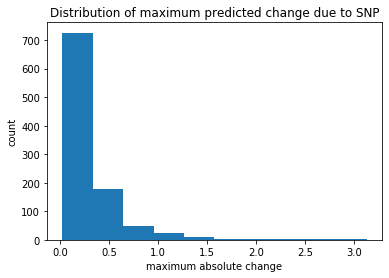

In [29]:
# plot distribution
plt.hist(snp_to_max_val.values())
plt.title("Distribution of maximum predicted change due to SNP")
plt.xlabel("maximum absolute change")
plt.ylabel("count")
plt.show()

In [ ]:
sorted(snp_to_max_val.items(), key=lambda tup: tup[1], reverse=True)[:25]